Compressible (ALA) 2-D mantle convection problem in a square box
================================================================

Our previous tutorial, which examined convection under the Truncated Anelastic Liquid
Approximation (TALA), can be easily modified to use an Anelastic Liquic Approximation (ALA),
as we demonstrate here.

This example
------------

We simulate compressible convection, for an isoviscous material,
under ALA. We specify $Ra=10^5$ and a dissipation number $Di=0.5$.
The model is heated from below $ T = 1.0 - (T0*\mbox{exp}(Di) - T0)$, cooled from the top (T=0)
in an enclosed 2-D Cartesian box (i.e. free-slip mechanical boundary
conditions on all boundaries).

Key differences relative to our previous tutorial, which examined convection under the TALA
approximation, are:
1. We no longer neglect the effect of dynamic pressure on buoyancy.
2. Specificiation of nullspaces for Stokes system, as this example has a non-constant
   pressure nullspace (vertical, decreasing with depth).

As with all examples, the first step is to import the gadopt module, which
provides access to Firedrake and associated functionality.

In [1]:
from gadopt import *

We next set up the mesh, function spaces, and specify functions to hold our solutions,
identically to our previous tutorials.

In [2]:
nx, ny = 40, 40  # Number of cells in x and y directions.
mesh = UnitSquareMesh(nx, ny, quadrilateral=True)  # Square mesh generated via firedrake
mesh.cartesian = True
boundary = get_boundary_ids(mesh)  # Boundary IDs

V = VectorFunctionSpace(mesh, "CG", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure function space (scalar)
Q = FunctionSpace(mesh, "CG", 2)  # Temperature function space (scalar)
Z = MixedFunctionSpace([V, W])  # Mixed function space.

z = Function(Z)  # A field over the mixed function space Z.
u, p = split(z)  # Returns symbolic UFL expression for u and p
z.subfunctions[0].rename("Velocity")
z.subfunctions[1].rename("Pressure")

We next specify the important constants for this problem, including those associated with the
compressible reference state. Note that for ease of extension, we specify these as functions,
allowing for spatial variability. Given that we account for the effect of dynamic pressure on
buoyancy in this example, we need to specify the bulk modulus (`chibar`), which differs to the TALA case.

In [3]:
X = SpatialCoordinate(mesh)
Ra = Constant(1e5)  # Rayleigh number
Di = Constant(0.5)  # Dissipation number
T0 = Constant(0.091)  # Non-dimensional surface temperature
rhobar = Function(Q, name="CompRefDensity").interpolate(exp((1.0 - X[1]) * Di))  # Reference density
Tbar = Function(Q, name="CompRefTemperature").interpolate(T0 * exp((1.0 - X[1]) * Di) - T0)  # Reference temperature

These fields are used to set up our Anelastic Liquid Approximation. Alongside adding the
requirement for specifying the bulk modulus, this is the key change relative to our tutorial under the TALA approximation.

In [4]:
approximation = AnelasticLiquidApproximation(Ra, Di, rho=rhobar, Tbar=Tbar)

As with the previous examples, we next set up a *Timestep Adaptor*,
for controlling the time-step length (via a CFL
criterion) as the simulation advances in time. For the latter,
we specify the initial time, initial timestep $\Delta t$, and number of
timesteps. Given the low Ra, a steady-state tolerance is also specified,
allowing the simulation to exit when a steady-state has been achieved.
The steady-state tolerance specified here is tight, and can be increased
to speed up the simulation, as required.

In [5]:
time = 0.0  # Initial time
delta_t = Constant(1e-6)  # Initial time-step
timesteps = 20000  # Maximum number of timesteps
t_adapt = TimestepAdaptor(delta_t, u, V, maximum_timestep=0.1, increase_tolerance=1.5)
steady_state_tolerance = 1e-9  # Used to determine if solution has reached a steady state.

We next set up and initialise our Temperature field. Note that here, we take into consideration
the non-dimensional surface temperature, T0. The full temperature field is also initialised.

In [6]:
T = Function(Q, name="Temperature")
T.interpolate((1.0 - (T0*exp(Di) - T0)) * ((1.0-X[1]) + (0.05*cos(pi*X[0])*sin(pi*X[1]))))
FullT = Function(Q, name="FullTemperature").assign(T+Tbar)

As noted above, this problem has a non-constant pressure nullspace (vertical, decreasing with depth)
for the right nullspace, and a constant nullspace for the transpose (left) nullspace.
We obtain the right nullspace (`Z_nullspace`) by providing the approximation object and subdomain marker
for the top boundary (where the pressure nullspace is referenced — see the
[nullspace visualisation](../visualise_ALA_p_nullspace) demo for more details). The left nullspace (`Z_nullspace_transpose`) is
handled identically to the previous [TALA](../2d_compressible_TALA) tutorial.

In [7]:
Z_nullspace = create_stokes_nullspace(
    Z, closed=True, rotational=False,
    ala_approximation=approximation, top_subdomain_id=boundary.top)
Z_nullspace_transpose = create_stokes_nullspace(
    Z, closed=True, rotational=False)

Boundary conditions are next specified.

In [8]:
stokes_bcs = {
    boundary.bottom: {'uy': 0},
    boundary.top: {'uy': 0},
    boundary.left: {'ux': 0},
    boundary.right: {'ux': 0},
}

temp_bcs = {
    boundary.bottom: {'T': 1.0 - (T0*exp(Di) - T0)},
    boundary.top: {'T': 0.0},
}

We next set up our output, in VTK format, including a file
that allows us to visualise the reference state.
We also open a file for logging and calculate our diagnostic outputs.

In [9]:
output_file = VTKFile("output.pvd")
ref_file = VTKFile('reference_state.pvd')
output_frequency = 570

plog = ParameterLog('params.log', mesh)
plog.log_str(
    "timestep time dt maxchange u_rms u_rms_surf ux_max nu_base "
    "nu_top energy avg_t rate_work_g rate_viscous energy_2")

gd = GeodynamicalDiagnostics(z, FullT, boundary.bottom, boundary.top)


We can now setup and solve the variational problem, for both the energy and Stokes equations,
passing in the approximation configured above. Note that relative to our TALA tutorial, we now
pass in different nullspace and transpose_nullspace objects to the stokes solver.

In [10]:
energy_solver = EnergySolver(T, u, approximation, delta_t, ImplicitMidpoint, bcs=temp_bcs)

stokes_solver = StokesSolver(
    z,
    T,
    approximation,
    bcs=stokes_bcs,
    constant_jacobian=True,
    nullspace=Z_nullspace,
    transpose_nullspace=Z_nullspace_transpose,
)

Next initiate the time loop, which runs until a steady-state solution has been attained:

In [11]:
for timestep in range(0, timesteps):

    # Write output:
    if timestep % output_frequency == 0:
        output_file.write(*z.subfunctions, T, FullT)
        ref_file.write(rhobar, Tbar)

    dt = t_adapt.update_timestep()
    time += dt

    # Solve Stokes sytem:
    stokes_solver.solve()

    # Temperature system:
    energy_solver.solve()

    # Compute diagnostics:
    energy_conservation = abs(abs(gd.Nu_top()) - abs(gd.Nu_bottom()))
    rate_work_against_gravity = assemble(approximation.work_against_gravity(u, T)*dx)
    rate_viscous_dissipation = assemble(approximation.viscous_dissipation(u)*dx)
    energy_conservation_2 = abs(rate_work_against_gravity - rate_viscous_dissipation)

    # Calculate L2-norm of change in temperature:
    maxchange = sqrt(assemble((T - energy_solver.T_old)**2 * dx))

    # Log diagnostics:
    plog.log_str(f"{timestep} {time} {float(delta_t)} {maxchange} "
                 f"{gd.u_rms()} {gd.u_rms_top()} {gd.ux_max(boundary.top)} {gd.Nu_bottom()} "
                 f"{gd.Nu_top()} {energy_conservation} {gd.T_avg()} "
                 f"{rate_work_against_gravity} {rate_viscous_dissipation} "
                 f"{energy_conservation_2}")

    # Calculate Full T
    FullT.assign(T+Tbar)

    # Leave if steady-state has been achieved:
    if maxchange < steady_state_tolerance:
        log("Steady-state achieved -- exiting time-step loop")
        break

Steady-state achieved -- exiting time-step loop


At the end of the simulation, once a steady-state has been achieved, we close our logging file
and checkpoint steady state temperature and Stokes solution fields to disk. These can later be
used to restart a simulation, if required.

In [12]:
plog.close()

with CheckpointFile("Final_State.h5", "w") as final_checkpoint:
    final_checkpoint.save_mesh(mesh)
    final_checkpoint.save_function(T, name="Temperature")
    final_checkpoint.save_function(z, name="Stokes")

We can visualise the final temperature field using Firedrake's
built-in plotting functionality.

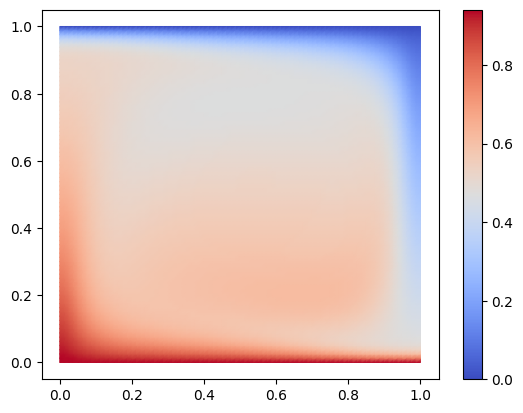

In [13]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
collection = tripcolor(T, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

The same can be done for the final Full temperature field.

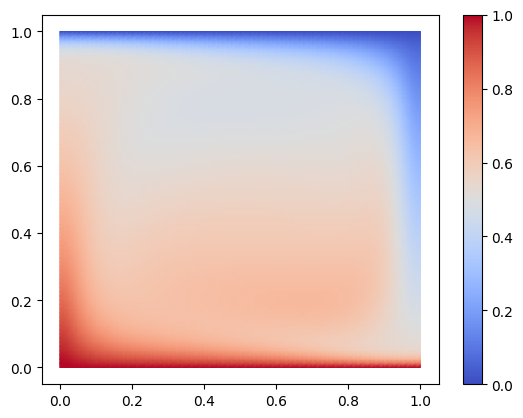

In [14]:
fig, axes = plt.subplots()
collection = tripcolor(FullT, axes=axes, cmap='coolwarm')
fig.colorbar(collection);